[*********************100%***********************]  1 of 1 completed
Cumulative Returns: 0.2822258223568038
Maximum Drawdown: 0.7311940776779813
Sharpe Ratio: -0.8212729632350688


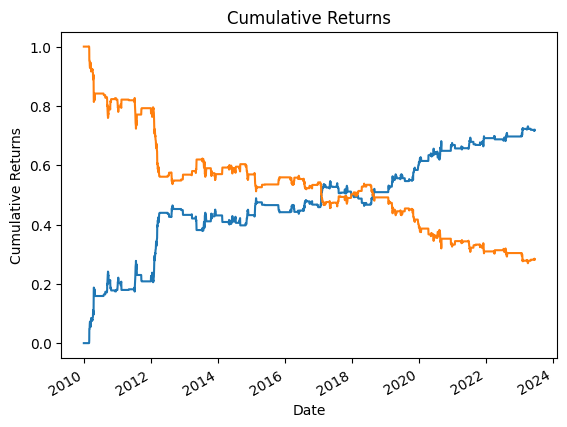

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Data Preparation
# Fetch historical data for the chosen Indian equity using yfinance
equity_ticker = "AAPL"  # Replace with the ticker symbol of the desired equity
equity_data = yf.download(equity_ticker, start="2010-01-01", end="2023-06-20")

# Step 2: Technical Indicator Calculation
# Calculate RSI values
def calculate_rsi(data, window):
    price_diff = data.diff(1)
    up = price_diff.where(price_diff > 0, 0)
    down = -price_diff.where(price_diff < 0, 0)
    average_gain = up.rolling(window=window).mean()
    average_loss = down.rolling(window=window).mean()
    relative_strength = average_gain / average_loss
    rsi = 100 - (100 / (1 + relative_strength))
    return rsi

equity_data['RSI'] = calculate_rsi(equity_data['Close'], window=14)

# Step 3: Candlestick Pattern Identification
def identify_bullish_engulfing(data):
    data['Engulfing'] = np.where((data['Close'].shift(1) < data['Open'].shift(1)) &
                                (data['Close'] > data['Open']) &
                                (data['Close'] > data['Open'].shift(1)) &
                                (data['Open'] < data['Close'].shift(1)), 1, 0)
    return data

equity_data = identify_bullish_engulfing(equity_data)

# Step 4: Strategy Implementation
# Define entry and exit rules
equity_data['Signal'] = np.where((equity_data['RSI'] < 30) & (equity_data['Engulfing'] == 1), 1,
                                 np.where((equity_data['RSI'] > 70) & (equity_data['Engulfing'] == 0), -1, 0))

# Step 5: Backtesting and Performance Evaluation
equity_data['Returns'] = equity_data['Signal'].shift(1) * equity_data['Close'].pct_change()
equity_data['Cumulative Returns'] = (1 + equity_data['Returns']).cumprod()
equity_data['Cumulative Returns'].fillna(1, inplace=True)
equity_data['Drawdown'] = equity_data['Cumulative Returns'].cummax() - equity_data['Cumulative Returns']
equity_data['Drawdown'].fillna(0, inplace=True)
equity_data['Drawdown'].plot(title='Maximum Drawdown')

# Calculate performance metrics
cumulative_returns = equity_data['Cumulative Returns'].iloc[-1]
maximum_drawdown = equity_data['Drawdown'].max()
sharpe_ratio = (equity_data['Returns'].mean() / equity_data['Returns'].std()) * np.sqrt(252)

print("Cumulative Returns:", cumulative_returns)
print("Maximum Drawdown:", maximum_drawdown)
print("Sharpe Ratio:", sharpe_ratio)

# Visualize the results
plt.plot(equity_data['Cumulative Returns'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
